# Zpráva k semestrální práci MI-PRC: Rychlá Fourierova transformace

**Marián Hlaváč** (hlavam30), marian.hlavac@fit.cvut.cz  
*Poslední aktualizace 15 Dec 2017*  
https://github.com/mmajko/FFT-cuda

## Zadání semestrální práce

Úkolem semestrální práce je implementovat sekvenční FFT algoritmus a převést jej na jednoduše paralelizovatelnou variantu. Následně výpočet tohoto algoritmu zrychlit pomocí programovacího modelu OpenACC a na závěr jej optimalizovat pro jednotky CUDA.

## Nástroje

K implementaci algoritmu byl využit jazyk C++, k aplikaci bylo napsáno několik podpůrných shell a Python skriptů a zpráva byla vypracována v Jupyter Notebooku.

## Algoritmus

Algoritmus byl implementován s využitím komplexních čísel, in-place, iterativně. Pro účely OpenACC pak byl upraven o formu vstupních a výstupních dat. Algoritmus pro OpenACC pracuje s polem float čísel, obsahující sekvenčně za sebou reálné a imaginární části.

Na GPU je překopírována jednodušší varianta pole, shodná s počtem vzorků v instanci, tedy **n** (protože imaginární části jsou na začátku práce s algoritmem nulové), GPU si vytvoří výše zmíněnou strukturu pro komplexní čísla o velikosti **2n**. Po dokončení práce je z GPU překopírována pouze poloviční velikost tohoto pole, jelikož druhá část pole obsahuje neirelevantní výsledky (důsledek Nyquist–Shannon sampling theorem). Bylo by ještě více efektivnější překopírovat pouze reálné části z tohoto pole, ale to by pravděpodobně díky zvolené struktuře bylo složitější a nemuselo by to ušetřit prostředky.

### Vstupní data

Pro účely měření byl vygenerován balíček instancí, které sloužily jako vstupní data. Nacházejí se v repozitáři ve složce `data/` a jsou tříděny podle formy dat nacházejících se uvnitř dat do jednotlivých adresářů. V adresářích se pak nacházejí samotná data. Názvy souborů popisují další vlastnosti dat, jako je počet vzorků a vzorkovací frekvenci.

Počty vzorků pro měření byly zvoleny v rozsahu 128 - 65536.

### Výstupní data

Výstup algoritmu se uloží vedle datových souborů, s příponou `.out`. Tyto data pak lze hezky zobrazit pomocí krátkého Python skriptu, který je vykreslí ve formě grafů.

![](./fancyscreenshot.png)


Na standardní výstup se pak vypíší informace o průběhu výpočtu. Tyto informace jsou úzce přizpůsobeny pro účely zprávy, obsahují tak místy redundantní data. Informace jsou odděleny čárkou, aby pak byla jednoduše převoditelná do CSV formátu.

Pořadí informací je následující: 
 - složka s daty
 - počet vzorků
 - vzorkovací frekvence
 - počet OpenACC gangů / CUDA nastavení
 - doba trvání v mikrosekundách
 
Předposlední položka je proměnlivá v závislosti na podúkolu semestrální práce (OpenACC vs CUDA).

Řádky s hodnotou 0 ve sloupci **num_gangs** představují výpočet na CPU.


## OpenACC

OpenACC umožňuje pomocí `pragma` direktiv rychle obohatit algoritmus o paralelismus.

### Výsledky

Výstupem programu, jak bylo výše zmíněno, jsou CSV data obsahující informace o průběhu výpočtů:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Konfigurace vizualizace dat
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13.0, 7.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 10

# Čtení dat z běhu programu
gpus = pd.read_csv("results/run-star.sh.o1912")
cpus = pd.read_csv("results/cpu")

data = pd.concat([gpus, cpus])
data

,folder,samples,sample_rate,num_gangs,elapsed_us
0,data/50Hz/,1024,44100,2,1309.00
1,data/50Hz/,1024,44100,4,843.00
2,data/50Hz/,1024,44100,8,568.00
3,data/50Hz/,1024,44100,16,417.75
4,data/50Hz/,1024,44100,32,346.50
...,...,...,...,...,...
25,data/500Hz+505Hz+12000Hz/,32768,44100,0,15517.20
26,data/500Hz+505Hz+12000Hz/,4096,44100,0,1539.50
27,data/500Hz+505Hz+12000Hz/,512,44100,0,155.00
28,data/500Hz+505Hz+12000Hz/,65536,44100,0,32967.20


### Závislost doby výpočtu na počtu vzorků

Průměr doby výpočtu společně na platformě CPU by měl naznačovat, jak obecně stoupá složitost výpočtu se vzrůstajícím počtem vzorků.

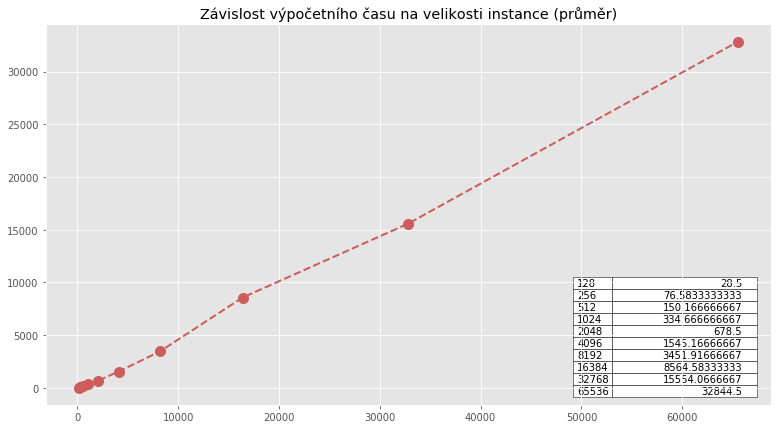

In [2]:
samplesvstime = data[data['num_gangs'] == 0].groupby('samples').mean()[['elapsed_us']]

plt.plot(samplesvstime, color='indianred', marker='o', markersize=10, ls='--', lw=2)
table = plt.table(cellText=samplesvstime.as_matrix(), loc='lower right', colWidths=[0.2], rowLabels=samplesvstime.index)
plt.title('Závislost výpočetního času na velikosti instance (průměr)')
plt.show()

### Zrychlení díky paralelizaci

Níže lze vidět jakých rychlostí výpočtu se dosáhlo při různých úrovních paralelizace (nastavení `num_gangs`) průměrně pro všechny velikosti instancí.

*Jako dříve zmíněno, num_gangs=0 značí výpočet na CPU.*

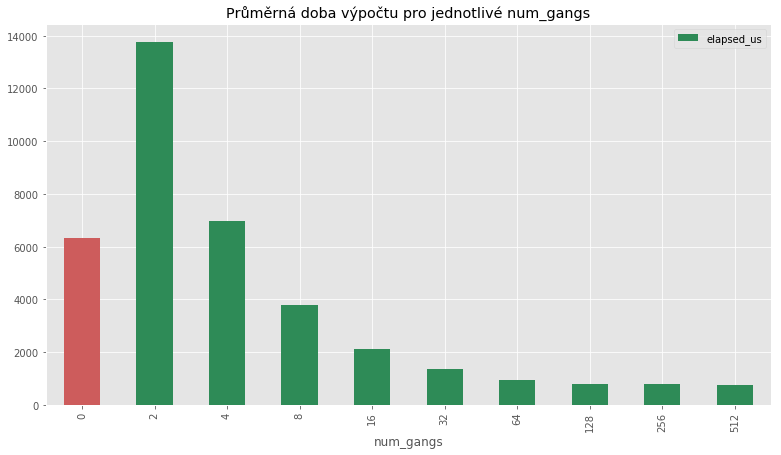

In [3]:
samplesvstime = data.groupby('num_gangs').mean()[['elapsed_us']]
ax = samplesvstime.plot(kind = 'bar', color='seagreen')
ax.set_title('Průměrná doba výpočtu pro jednotlivé num_gangs')
ax.patches[0].set_facecolor('indianred')

### Zrychlení díky paralelizaci relativně k velikosti instancí

K tomuto pokusu jsem vybral čtyři vzorky a pozoroval stejné vlastnosti jako na grafu výše, jen s tím rozdílem, že se nejedná o průměr všech velikostí instancí.

**Velikosti instancí jsou následující: 128, 1024, 8192 a 65536**

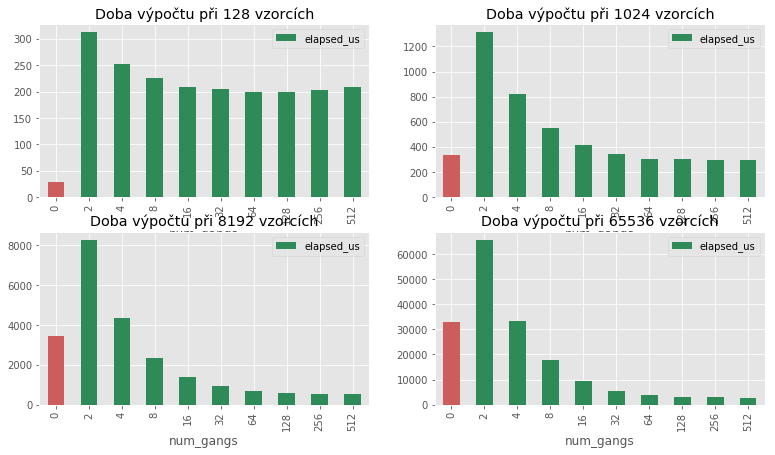

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for st in [[128, axes[0, 0]], [1024, axes[0, 1]], [8192, axes[1, 0]], [65536, axes[1, 1]]]:
    ax = data[data['samples'] == st[0]].groupby('num_gangs').mean()[['elapsed_us']].plot(kind='bar', color='seagreen', ax=st[1])
    ax.set_title('Doba výpočtu při {} vzorcích'.format(st[0]))
    ax.patches[0].set_facecolor('indianred')

### Závěr k implementaci OpenACC

Režie kopírování dat na GPU je náročná a tak průměrně při num_gangs menším nebo rovno 4 nebylo dosaženo žádného zrychlení, ale právě naopak. Průměrně platilo, že s vyšším počtem num_gangs je ale výpočet rychlejší a efektivita paralelizace končí u num_gangs 256 a vyšší.

U menších instancí je tento fakt mnohem znatelnější, např. u instance o velikosti *128* lze pozorovat, že paralelizace vůbec nepomohla. Naopak u instance o velikosti *65536* lze pozorovat až `11,2x` zrychlení oproti výpočtu na CPU.


## CUDA

CUDA část je napsána v **CUDA C** a kompilována pomocí `nvcc`.

Velmi podobným způsobem bylo zkoumáno zrychlení při přepisu z OpenACC do CUDA. Kód pro CUDA je o něco přehlednější, kvalitnější a pokročilejší, než pro OpenACC. Aby došlo ke skutečně zrychlující paralelizaci, jsou paralelizovány dva cykly v iterativním výpočtu FFT. 

Změnily se mírně i použité datové struktury, použit byl datový typ `float2`.

### Balancování cyklů

Dva cykly obaluje ještě jeden cyklus, který je opakován log2(n) krát a je spouštěn sekvenčně, dva paralelizované cykly uvnitř něj zachovávají stejný počet provedení nejvnitřnějšího procesu (`n/2` krát), ale mění se počty opakování jednotlivých cyklů. Zatímco vnějšímu cyklu počty opakování klesají (pro `n = 8K` je to `4K, 2K ... 2`), vnitřnímu cyklu počty opakování rovnocenně stoupají (pro `n=8K` je to `1, 2, ..., 2K`).

![](./graphic.jpg)

Stanovil jsem tak parametr balance, jehož změnou chci ověřit, zda skutečně je správná teoretická úvaha nastavit tento parametr v rozsahu `n/3` až `n/4` pro nejlepší rozdělení práce a nejrychlejší provedení výpočtu.

Parametr určuje, od které hodnoty `n/m` bude který cyklus paralelizován (nevyužil jsem funkce kernel v kernelech), jestli vnější, nebo vnitřní.

### Počty bloků a vláken

Do programu jsem zahrnul pouze jeden parametr přímo ovlivňující paralelizaci, a to je počet vláken na každý blok.

Uvažoval jsem `r` jako počet opakování cyklu, který chci paralelizovat, a `threads` jako počet vláken na každý blok. Počet bloků každému paralelizovanému cyklu jsem nastavil jako `ceil(r / threads)`.

### Výsledky

In [5]:
# Čtení dat z běhu programu
cudata = pd.read_csv("results/cuda-outputs.csv")
cudata

,file,samples,sample_rate,threads,balance,elapsed_us
0,data/50Hz/128smp@44100.dat,128,44100,1,2,624
1,data/50Hz/128smp@44100.dat,128,44100,1,2,541
2,data/50Hz/128smp@44100.dat,128,44100,1,2,804
3,data/50Hz/128smp@44100.dat,128,44100,1,4,850
4,data/50Hz/128smp@44100.dat,128,44100,1,4,861
...,...,...,...,...,...,...
4285,data/50Hz+500Hz/8192smp@44100.dat,8192,44100,1024,2048,37057
4286,data/50Hz+500Hz/8192smp@44100.dat,8192,44100,1024,2048,37012
4287,data/50Hz+500Hz/8192smp@44100.dat,8192,44100,1024,4096,66706
4288,data/50Hz+500Hz/8192smp@44100.dat,8192,44100,1024,4096,66830


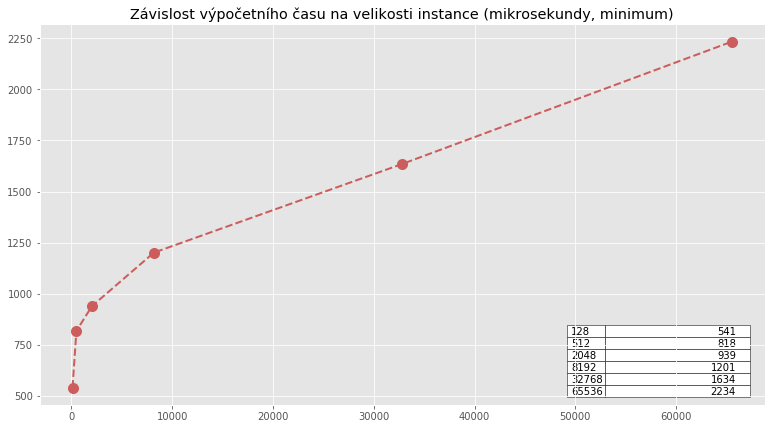

In [6]:
cusamplesvstime = cudata.groupby('samples').min()[['elapsed_us']]

plt.plot(cusamplesvstime, color='indianred', marker='o', markersize=10, ls='--', lw=2)
table = plt.table(cellText=cusamplesvstime.as_matrix(), loc='lower right', colWidths=[0.2], rowLabels=cusamplesvstime.index)
plt.title('Závislost výpočetního času na velikosti instance (mikrosekundy, minimum)')
plt.show()

#### Šum výsledků

Jako první vlastnosti jsem si všiml znatelného šumu mezi jednotlivými výsledky se stejnými parametry. Nepodařilo se zjistit příčinu, ani co ovlivňuje jejich velikost.

Jako částečné řešení jsem tak zvolil opakované výpočty, které sice znásobily čekání na výsledná data, ale poskytly větší přesnost. Vygenerovaná data jsou tak třikrát opakovaná.

#### Počty vláken

Měnil jsem parametr počtů vláken v rozsahu `1 - 1024`. Překvapivě tento parametr neovlivnil dobu výpočtu tak drasticky, jako jsem očekával.

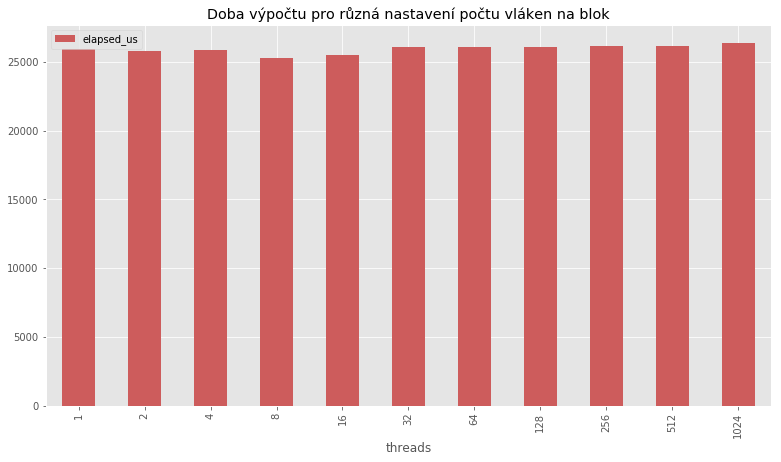

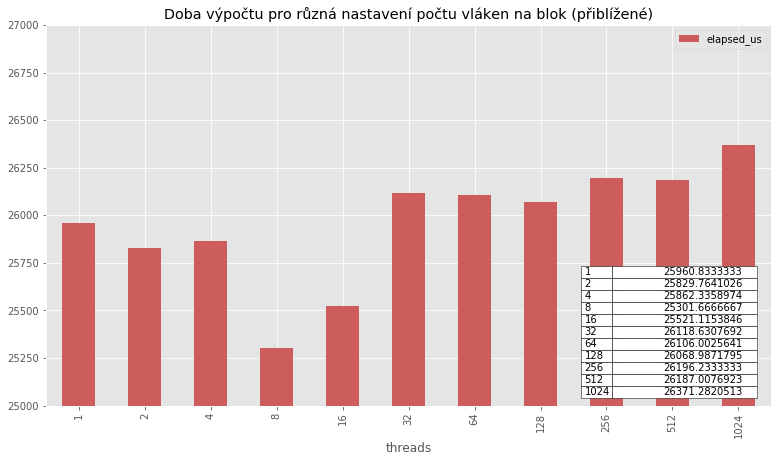

In [7]:
threadsvstime = cudata.groupby('threads').mean()[['elapsed_us']]
threadsvstime.plot(color='indianred', kind = 'bar')
plt.title('Doba výpočtu pro různá nastavení počtu vláken na blok')
threadsvstime.plot(color='indianred', kind = 'bar')
plt.ylim([25000, 27000])
plt.title('Doba výpočtu pro různá nastavení počtu vláken na blok (přiblížené)')
table = plt.table(cellText=threadsvstime.as_matrix(), loc='lower right', colWidths=[0.2], rowLabels=threadsvstime.index, zorder=1)

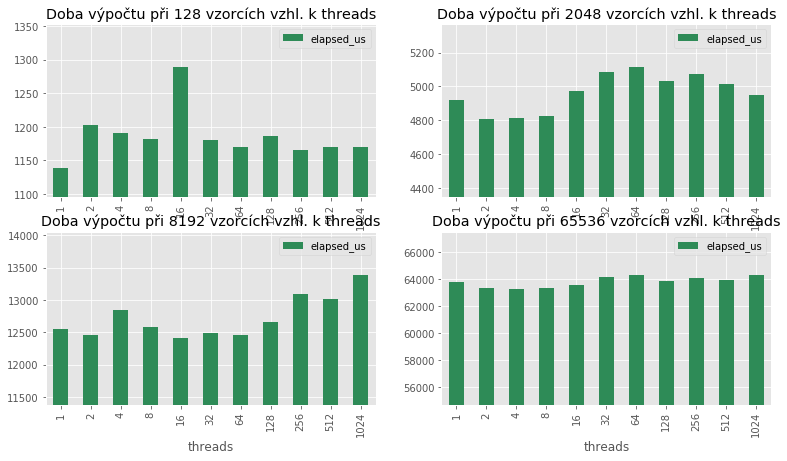

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for st in [[128, axes[0, 0]], [2048, axes[0, 1]], [8192, axes[1, 0]], [65536, axes[1, 1]]]:
    maximum = cudata[cudata['samples'] == st[0]].groupby('threads').mean()['elapsed_us'].max()
    ax = cudata[cudata['samples'] == st[0]].groupby('threads').mean()[['elapsed_us']].plot(kind='bar', color='seagreen', ax=st[1])
    ax.set_title('Doba výpočtu při {} vzorcích vzhl. k threads'.format(st[0]))
    ax.set_ylim([maximum * 0.85, maximum * 1.05])



Nejlepších hodnot bylo dosáhnuto při nízkých hodnotách tohoto parametru. Průměrně nejrychlejších úspěchů bylo dosáhnuto s počtem vláken na blok roven `8`.

#### Balancování paralelizovaných cyklů

Jak bylo výše popsáno, ověřoval jsem doby výpočtu pro různá nastavení parametru balance.


Text(0.5,1,'Doba výpočtu pro různá nastavení parametru balance (přiblížené)')

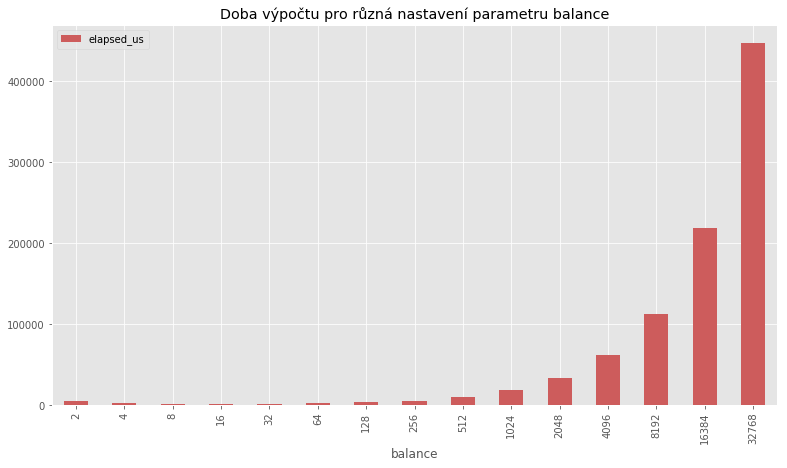

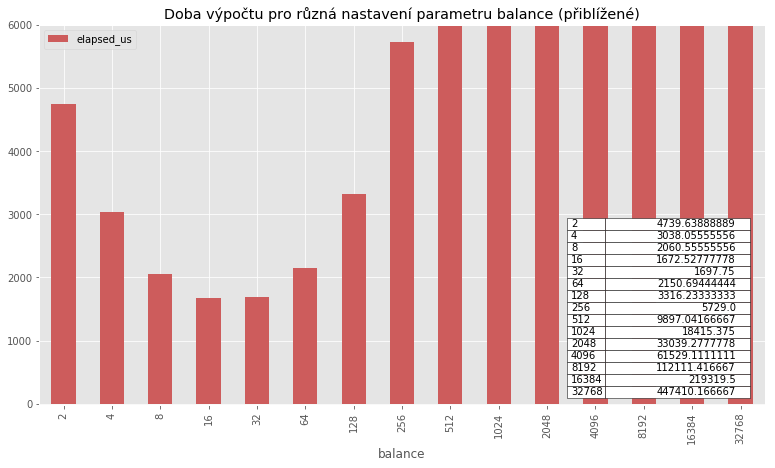

In [9]:
balancevstime = cudata[cudata['threads'] == 8].groupby('balance').mean()[['elapsed_us']]
balancevstime.plot(color='indianred', kind = 'bar')
plt.title('Doba výpočtu pro různá nastavení parametru balance')
balancevstime.plot(color='indianred', kind = 'bar')
plt.ylim([-20, 6000])
table = plt.table(cellText=balancevstime.as_matrix(), loc='lower right', colWidths=[0.2], rowLabels=balancevstime.index, zorder=1)

plt.title('Doba výpočtu pro různá nastavení parametru balance (přiblížené)')

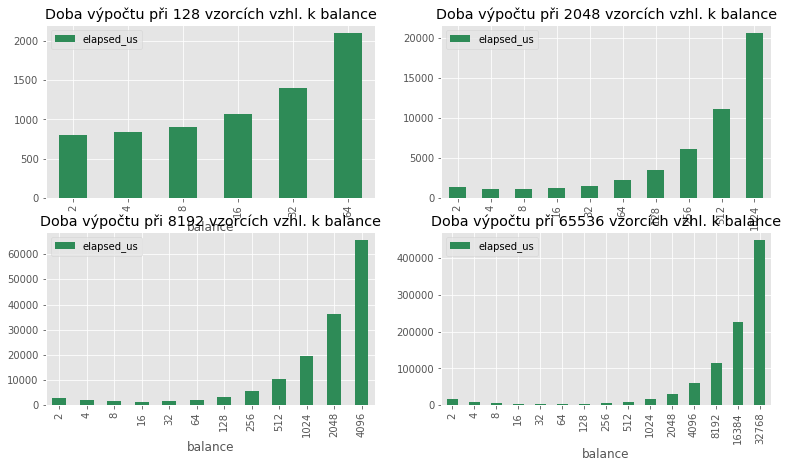

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for st in [[128, axes[0, 0]], [2048, axes[0, 1]], [8192, axes[1, 0]], [65536, axes[1, 1]]]:
    ax = cudata[cudata['samples'] == st[0]].groupby('balance').mean()[['elapsed_us']].plot(kind='bar', color='seagreen', ax=st[1])
    ax.set_title('Doba výpočtu při {} vzorcích vzhl. k balance'.format(st[0]))

Parametr balance tak dokázal celé zefektivnění času podpořit, nebo naopak obrátit do negativních hodnot a z výpočtu udělat výpočet delší, než kdyby byl počítán sekvenčně. Volba tohoto parametru tak musí být opatrná.

#### Nejlepší výsledky

Pro každý počet vzorků jsem vypsal nejrychlejší výpočet a jeho parametry.

Skutečně lze i prakticky potvrdit, že nejvhodnější nastavení parametrů je:
 - počet vláken nastaven na nízké hodnoty (závislost na n lze určit obtížně, ale zdá se přibližně jako dvacetina procenta)
 - parametr balancování nastavit na n/4



In [11]:
cudata.loc[cudata.groupby('samples')['elapsed_us'].idxmin()]

,file,samples,sample_rate,threads,balance,elapsed_us
1,data/50Hz/128smp@44100.dat,128,44100,1,2,541
3351,data/50Hz+500Hz/512smp@44100.dat,512,44100,512,2,818
2348,data/50Hz+500Hz/2048smp@44100.dat,2048,44100,1,4,939
873,data/50Hz/8192smp@44100.dat,8192,44100,4,16,1201
1372,data/50Hz/32768smp@44100.dat,32768,44100,16,64,1634
3596,data/50Hz+500Hz/65536smp@44100.dat,65536,44100,16,64,2234


### Porovnání s OpenACC

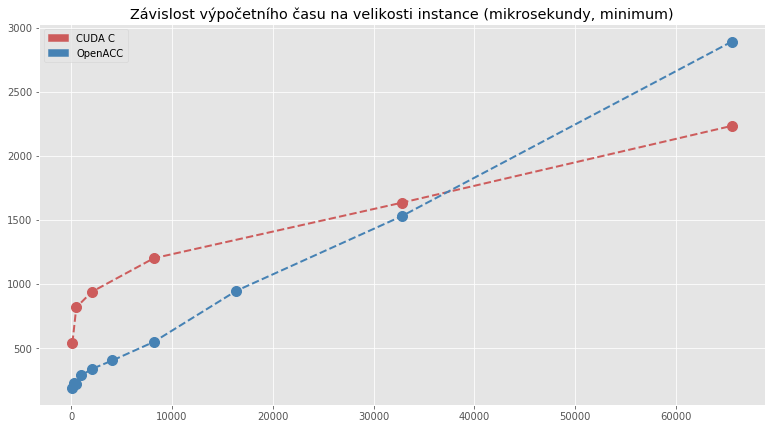

In [12]:
import matplotlib.patches as mpatches
oaccvscu = data[data['num_gangs'] == 128].groupby('samples').min()[['elapsed_us']]
plt.plot(cusamplesvstime, color='indianred', marker='o', markersize=10, ls='--', lw=2)
plt.plot(oaccvscu, color='steelblue', marker='o', markersize=10, ls='--', lw=2)
plt.title('Závislost výpočetního času na velikosti instance (mikrosekundy, minimum)')
p1 = mpatches.Patch(color='indianred', label='CUDA C')
p2 = mpatches.Patch(color='steelblue', label='OpenACC')
plt.legend(handles=[p1, p2])

plt.show()
plt.show()

Na grafu jde vidět, že se CUDA varianta vyplatí až při větších instancích. Při menších instancích si OpenACC vedlo lépe.

### Porovnání s knihovní funkcí cufft

Ukázkovým kódem jsem se pokusil porovnat mou implementaci s knihovní funkcí cufft.

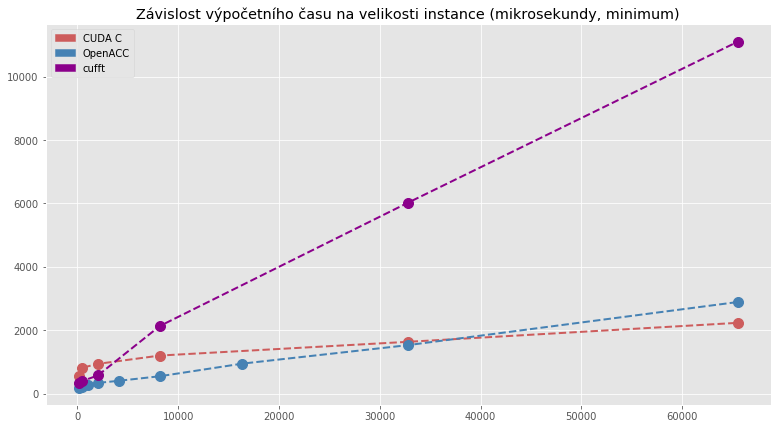

In [13]:
import matplotlib.patches as mpatches
cufft = pd.read_csv("results/cufft.csv").groupby('samples').min()[['elapsed_us']]
oaccvscu = data[data['num_gangs'] == 128].groupby('samples').min()[['elapsed_us']]
plt.plot(cusamplesvstime, color='indianred', marker='o', markersize=10, ls='--', lw=2)
plt.plot(oaccvscu, color='steelblue', marker='o', markersize=10, ls='--', lw=2)
plt.plot(cufft, color='darkmagenta', marker='o', markersize=10, ls='--', lw=2)
plt.title('Závislost výpočetního času na velikosti instance (mikrosekundy, minimum)')
p1 = mpatches.Patch(color='indianred', label='CUDA C')
p2 = mpatches.Patch(color='steelblue', label='OpenACC')
p3 = mpatches.Patch(color='darkmagenta', label='cufft')
plt.legend(handles=[p1, p2, p3])
plt.show()

K mému překvapení si pro větší instance vedla knihovna hůře, než CUDA a OpenACC dohromady.

Důvod bych viděl v plánovači, který je uzpůsobem spíše na dávkové zpracování a je nutné jej správně nastavit abychom dosáhli lepších rychlostí.

Měření probíhalo mezi plánovačem a samotným FFT procesem. Plánování zabírá největší dobu výpočtu, samotný FFT proces trval v průměru čtvrtinu celého času. Nicméně plánování je nutné započítat taky, pokud chceme porovnávat s vlastní implementaci. (plánování ve vlastní implementaci není)

```c++
// Start the stopwatch
auto start = chrono::high_resolution_clock::now();

// CUFFT plan
cufftHandle plan;
cufftPlan1d(&plan, new_size, CUFFT_C2R, 1);

// CUFTT exec
cufftExecC2R(plan, (cufftComplex *)d_signal, (cufftReal *)d_signal);

auto finish = chrono::high_resolution_clock::now();
```

Toto měření by dle mého názoru dopadlo lépe, kdybychom cufft funkci předali kompletní data sjednocená za sebou a nechali plánovač udělat svou práci.

Kvůli porovnání jsem však nechtěl měnit celou strukturu připravených dat a procesů mého programu.


### Závěr k implementaci CUDA

Subjektivně jsem očekával lepší výsledky. Zároveň si stále nejsem jist správností postupu balancování paralelizace mezi dvěmi cykly.

V tomto případě by možná byly vhodné varianty, kdy se celý algoritmus přepíše do jiné formy (s jedním cyklem, místo více vnořených), nebo se na vnořené cykly použijí kernely v kernelech. Obě varianty ale naznačují, že budou pracné.




## Závěr

OpenACC byla mnohem pracnější a nervydrásající záležitost. Subjektivně mám pocit, že v CUDA C program dělá přesně to, co něm člověk chce a podle toho také dopadly i výsledky. S CUDA C se ovšem pracovalo daleko lépe, než s OpenACC.

OpenACC ovšem pro malé instance nastavilo paralelizaci lépe, než já v CUDA C. Celá semestrální práce nabízí spoustu dalších směrů, jak by se dal výpočet experimentálně vylepšit.

Obecně však semestrální práce byla dobrou zkušeností.

Zdrojové kódy programu lze najít na GitHubu. Odkaz je v hlavičce zprávy.